<a href="https://colab.research.google.com/github/stepan-zykov/DLS/blob/main/second_semester/HW3/Zykov_language_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.3 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

Оставим только предложения с числом слов меньше word_threshold. Для этого отфильтруем предложения с числом пробелов >= word_threshold - 1.

In [ ]:
sentences = []
word_threshold = 32
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if x.strip().count(' ') < word_threshold - 1]
    )
# Получить отдельные предложения и поместить их в sentences

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 219936


Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()
for sentence in tqdm(sentences):
    for word in word_tokenize(sentence, language='english'):
      words[word] += 1
# Расчет встречаемости слов

  0%|          | 0/219936 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set()
vocab_size = 40000
sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=True)
cut_words = list(x[0] for x in sorted_words[:40000])
vocab.update(cut_words)
vocab.update(['<unk>', '<bos>', '<eos>', '<pad>'])
# Наполнение словаря

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits,
                             batch['target_ids'].to(device).flatten()
                             )
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
def train_model(model, criterion, optimizer, train_dataloader, eval_dataloader, num_epochs):
    train_losses = []
    eval_perplexities = []

    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training_epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].to(device).flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        train_losses.append(sum(epoch_losses) / len(epoch_losses))
        eval_perplexities.append(evaluate(model, criterion, eval_dataloader))

    return train_losses, eval_perplexities

Определите архитектуру модели и обучите её.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, num_rnn_layers: int, rnn_layer_type: nn.Module, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = rnn_layer_type(hidden_dim, hidden_dim, num_layers=num_rnn_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

### Первый эксперимент (2 балла)

Используем ванильный RNN с одним слоем, hidden_dim=256 как первый вариант

In [ ]:
base_model = LanguageModel(hidden_dim=256, num_rnn_layers=1,
                           rnn_layer_type=nn.RNN, vocab_size=len(vocab)).to(device)
base_optimizer = torch.optim.Adam(base_model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
base_losses, base_perplexities = train_model(base_model, criterion, base_optimizer, train_dataloader, eval_dataloader, 10)

Training_epoch 0::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 1::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 2::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 3::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 4::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 5::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 6::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 7::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 8::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 9::   0%|          | 0/1375 [00:00<?, ?it/s]

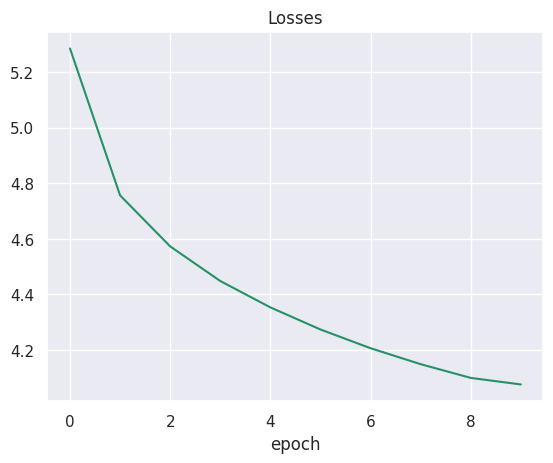

In [ ]:
plt.plot(np.arange(len(base_losses)), base_losses)
plt.title('Losses')
plt.xlabel('epoch')
plt.show()

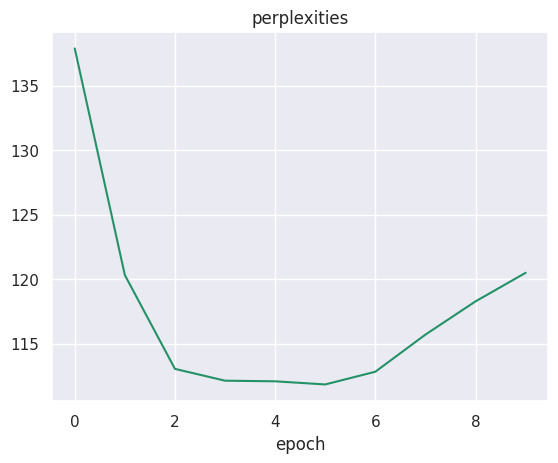

In [ ]:
plt.plot(np.arange(len(base_perplexities)), base_perplexities)
plt.title('perplexities')
plt.xlabel('epoch')
plt.show()

После 5 эпох наблюдается переобучение.

Перплексия на тестовой выборке

In [ ]:
base_perplexity = evaluate(base_model, criterion, test_dataloader)
base_perplexity

118.7654121310212

### Второй эксперимент (2 балла)

Попробуем заменить ванильный RNN на GRU и уменьшить количество эпох до 6.

In [ ]:
GRU_model = LanguageModel(hidden_dim=256, num_rnn_layers=1,
                           rnn_layer_type=nn.GRU, vocab_size=len(vocab)).to(device)
GRU_optimizer = torch.optim.Adam(GRU_model.parameters())

In [ ]:
GRU_losses, GRU_perplexities = train_model(GRU_model, criterion, GRU_optimizer, train_dataloader, eval_dataloader, 6)

Training_epoch 0::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 1::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 2::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 3::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 4::   0%|          | 0/1375 [00:00<?, ?it/s]

Training_epoch 5::   0%|          | 0/1375 [00:00<?, ?it/s]

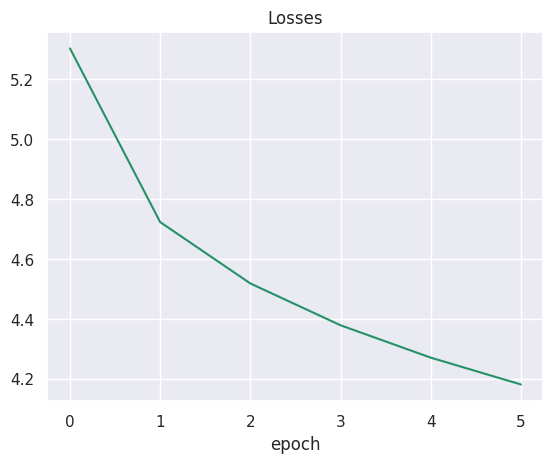

In [ ]:
plt.plot(np.arange(len(GRU_losses)), GRU_losses)
plt.title('Losses')
plt.xlabel('epoch')
plt.show()

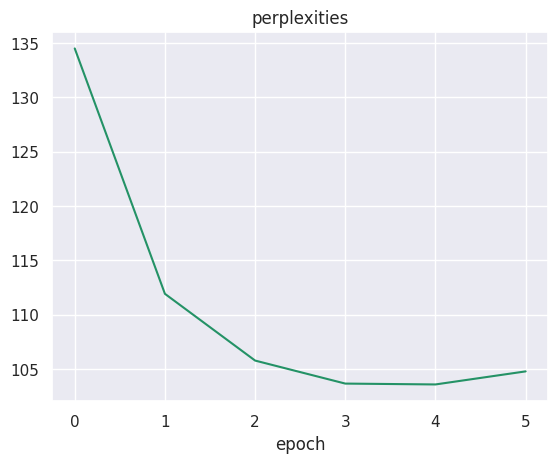

In [ ]:
plt.plot(np.arange(len(GRU_perplexities)), GRU_perplexities)
plt.title('perplexities')
plt.xlabel('epoch')
plt.show()

Перплексия на тестовой выборке

In [ ]:
GRU_perplexity = evaluate(GRU_model, criterion, test_dataloader)
GRU_perplexity

103.06964865396189

После 4 эпохи снова наблюдается рост перплексии на валидационной выборке, что говорит о начале переобучения. Обученная модель на тестовой выборке дала перплексию 103.

### Третий эксперимент

Попробуем добавить второй слой в GRU и уменьшить количество эпох до 5.

In [ ]:
double_GRU_model = LanguageModel(hidden_dim=256, num_rnn_layers=2,
                           rnn_layer_type=nn.GRU, vocab_size=len(vocab)).to(device)
double_GRU_optimizer = torch.optim.Adam(double_GRU_model.parameters())

In [ ]:
double_GRU_losses, double_GRU_perplexities = train_model(double_GRU_model,
                                                         criterion, double_GRU_optimizer,
                                                         train_dataloader, eval_dataloader, 5)

Training_epoch 0::   0%|          | 0/5499 [00:00<?, ?it/s]

Training_epoch 1::   0%|          | 0/5499 [00:00<?, ?it/s]

Training_epoch 2::   0%|          | 0/5499 [00:00<?, ?it/s]

Training_epoch 3::   0%|          | 0/5499 [00:00<?, ?it/s]

Training_epoch 4::   0%|          | 0/5499 [00:00<?, ?it/s]

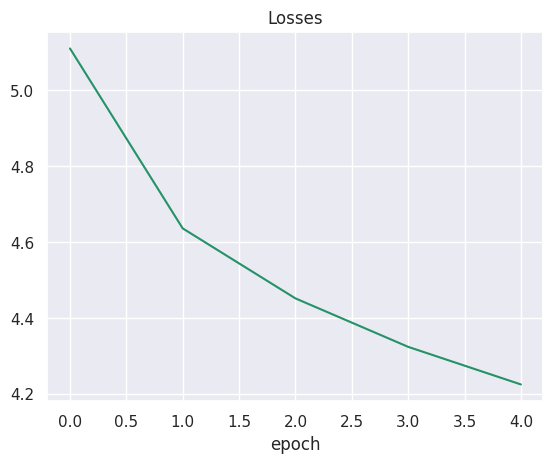

In [ ]:
plt.plot(np.arange(len(double_GRU_losses)), double_GRU_losses)
plt.title('Losses')
plt.xlabel('epoch')
plt.show()

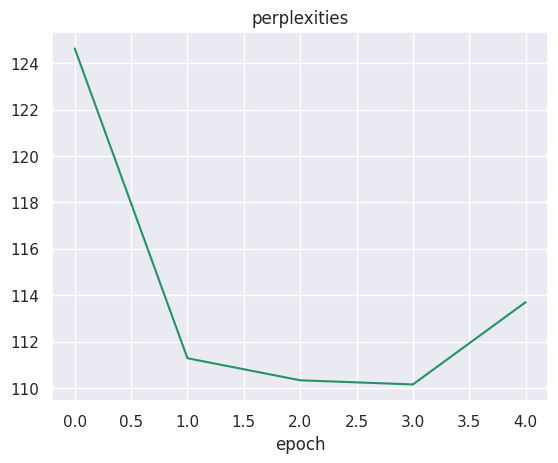

In [ ]:
plt.plot(np.arange(len(double_GRU_perplexities)), double_GRU_perplexities)
plt.title('perplexities')
plt.xlabel('epoch')
plt.show()

Перплексия на тестовой выборке

In [ ]:
double_GRU_perplexity = evaluate(double_GRU_model, criterion, test_dataloader)
double_GRU_perplexity

113.17932138332101

Также после 4 эпохи наблюдаем переобучение. Перплексия составила 113.

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Изменияемые параметры и результаты экспериментов представлены в таблице.


| № | Тип слоя | Количество слоев | Число эпох | Перплексия |
|---|----------|----------|----------|----------|
| 1 | RNN   | 1   | 10   | 119   |
| 1 | GRU   | 1   | 6   | 103   |
| 1 | GRU   | 2   | 5   | 113   |


Замена ванильного RNN слоя на GRU снижает перплексию. При этом наилучшего результата на тестовой выборке удалось достичь при 1 GRU слое, обучив модель на 6 эпохах. Перплексия составила 103.

Во всех случаях наблюдалось переобучение, поэтому при дальнейшей оптимизации следует обратить особое внимание на выбор числа эпох. Также можно подобрать размерность вектора скрытого состояния, поэкспериментировать с выбором оптимизатора, числа и типа рекурсивных слоев.